# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import concat, explode, lit, min, max, split, datediff, to_date, countDistinct
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DateType
import datetime

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, DecisionTreeClassificationModel
from pyspark.ml.classification import RandomForestClassificationModel, RandomForestClassifier, NaiveBayes, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer, StandardScaler, Normalizer, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.mllib.evaluation import MulticlassMetrics

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

% matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.createOrReplaceTempView("df_table")

In [4]:
df.persist()

DataFrame[_corrupt_record: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
spark.sql("SELECT COUNT(*) \
           FROM df_table   ").collect()

[Row(count(1)=110149)]

In [7]:
spark.sql("SELECT COUNT(*) \
           FROM df_table   \
           WHERE userId =''").collect()

[Row(count(1)=3290)]

In [8]:
110149-3290

106859

In [9]:
spark.sql("SELECT COUNT(*) \
           FROM df_table   \
           WHERE sessionId = 0").collect()

[Row(count(1)=0)]

In [10]:
df = spark.sql("SELECT * \
           FROM df_table  \
           WHERE (userId <> '') AND (sessionId <> 0)")

In [11]:
df.toPandas().head(2)

,_corrupt_record,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,None,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9


In [12]:
#Column 'dateTime': Actual UTC date based on timestamp
get_datetime = udf(lambda x: datetime.datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))
df = df.withColumn("dateTime", get_datetime(df.ts))

#Add dateTime with accuracy by day and month:
get_datetime = udf(lambda x: datetime.datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d'))
df = df.withColumn("dateTime_day", get_datetime(df.ts))

get_datetime = udf(lambda x: datetime.datetime.utcfromtimestamp(x/1000).strftime('%Y-%m'))
df = df.withColumn("dateTime_month", get_datetime(df.ts))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
df.createOrReplaceTempView("df_table")

#Preliminary Analysis

In [14]:
#timeframe of data:
min_date, max_date = df.select(min('dateTime'), max('dateTime')).first()
min_date, max_date

('2018-10-01 00:01:57', '2018-11-01 11:37:23')

In [15]:
# number of unique users:
userId_distinct = df.select(countDistinct('userId')).collect()[0][0]
print('Number of distinct users: {}'.format(userId_distinct))

# number of unique songs:
song_distinct = df.select(countDistinct('song')).collect()[0][0]
print('Number of distinct songs: {}'.format(song_distinct))

# number of unique artists:
artist_distinct = df.select(countDistinct('artist')).collect()[0][0]
print('Number of distinct artists: {}'.format(artist_distinct))

Number of distinct users: 143
Number of distinct songs: 34155
Number of distinct artists: 12458


In [16]:
# number of songs listened to overall during this timeframe by these users:
songs_total = df.select(count('song')).collect()[0][0]
print('Total number of songs: {}'.format(songs_total))

Total number of songs: 87978


In [17]:
#average number of songs listened to per user:
avg_songs_per_user = songs_total / userId_distinct
print('Average number of songs per user within timeframe of data: {0:.0f}'.format(avg_songs_per_user))

Average number of songs per user within timeframe of data: 615


In [18]:
get_churn_canc = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0)
df = df.withColumn("churnByCancellation", get_churn_canc(df.page))

In [19]:
get_churn_down = udf(lambda x: 1 if x == 'Submit Downgrade' else 0)
df = df.withColumn("churnByDowngrade", get_churn_down(df.page))

In [20]:
df.createOrReplaceTempView("df_table")
spark.sql('''
           SELECT * 
           FROM df_table   
           WHERE page = "Submit Downgrade" 
           ''').toPandas().head(2)

,_corrupt_record,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,...,song,status,ts,userAgent,userId,dateTime,dateTime_day,dateTime_month,churnByCancellation,churnByDowngrade
0,None,None,Logged In,Kael,M,47,Baker,None,paid,"Kingsport-Bristol-Bristol, TN-VA",...,None,307,1538393619000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131,2018-10-01 11:33:39,2018-10-01,2018-10,0,1
1,None,None,Logged In,Calvin,M,17,Marshall,None,paid,"Pittsburgh, PA",...,None,307,1538516445000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",38,2018-10-02 21:40:45,2018-10-02,2018-10,0,1


In [21]:
df.take(1)

[Row(_corrupt_record=None, artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', dateTime='2018-10-01 00:01:57', dateTime_day='2018-10-01', dateTime_month='2018-10', churnByCancellation='0', churnByDowngrade='0')]

In [22]:
#order by userId, then dateTime
df = df.orderBy(["userId", "dateTime"], ascending=[1, 1])

In [23]:
df.createOrReplaceTempView("df_table")
spark.sql("SELECT DISTINCT auth \
           FROM df_table").toPandas().head(2)

,auth
0,Cancelled
1,Logged In


In [24]:
df.createOrReplaceTempView("df_table")
spark.sql("SELECT DISTINCT level \
           FROM df_table").toPandas()

,level
0,free
1,paid


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### RECENCY (not used in the end)
Counter of days before cancellation.

In [25]:
#Create column that countains the cancellation date in the respective row and backfills it. 
#Everything that potentially comes after will be NaN
df.createOrReplaceTempView("df_table")
df = spark.sql('''SELECT a.*, b.dateTime AS PENDING_CANCELLATION_DATE
                  FROM df_table a
                  LEFT JOIN (
                      SELECT userId, dateTime
                      FROM df_table
                      WHERE churnByCancellation=1
                  ) b
                  ON a.userId = b.userId
                  ''')

In [26]:
df = df.withColumn("RECENCY", 
              datediff(to_date(df.PENDING_CANCELLATION_DATE),
                       to_date(df.dateTime)))

### Aggregating info grouped by userId:

In [27]:
df.createOrReplaceTempView("df_table")
df1 = spark.sql('''
          SELECT 
              a.userId,
              MAX(a.gender) AS gender,
              COUNT(DISTINCT a.sessionId) AS NUM_SESSIONS_DISTINCT,
              COUNT(DISTINCT a.artist) AS NUM_ARTISTS_DISTINCT,
              COUNT(DISTINCT a.song) AS NUM_SONGS_DISTINCT,
              COUNT(a.song) AS NUM_SONGS,
              CASE WHEN SUM(a.churnByCancellation) = 0 THEN 0 ELSE 1 END AS CHURNED
          FROM df_table a
          GROUP BY a.userId
          ORDER BY a.userId ASC
          ''')

In [28]:
#Add level (paid / free)

df1.createOrReplaceTempView("df_table_aggregated")
df1 = spark.sql('''
                  SELECT a.*,
                  CASE WHEN level.LAST_LEVEL = 'paid' THEN 1 ELSE 0 END AS LAST_LEVEL

                  
                  FROM df_table_aggregated a
    
                  
                  LEFT JOIN (
                      SELECT
                          userId,
                          MAX(dateTime) AS LAST_DATE
                      FROM df_table
                      GROUP BY userId  
                  ) last_date
                  ON a.userId = last_date.userId
                  

                  LEFT JOIN (
                      SELECT
                          userId,
                          dateTime,
                          MAX(level) LAST_LEVEL
                      FROM df_table
                      GROUP BY userId, dateTime
                  ) level
                  ON last_date.LAST_DATE = level.dateTime AND last_date.userId = level.userId
          ''')

df1 = df1.fillna(0, subset=['LAST_LEVEL'])

In [29]:
# Add more features based on page visits

df1.createOrReplaceTempView("df_table_aggregated")
df1 = spark.sql('''
                  SELECT a.*, 
                  downgrade.DOWNGRADE,
                  friend.FRIENDS_ADDED,
                  rating_good.RATINGS_GIVEN_GOOD,
                  rating_bad.RATINGS_GIVEN_BAD,
                  avg_ratings_good.AVG_RATINGS_PER_DAY_GOOD,
                  avg_ratings_bad.AVG_RATINGS_PER_DAY_BAD,
                  playlist.COUNT AS SONGS_ADDED_TO_PLAYLIST,
                  avg.AVG_SONGS_PER_SESSION, 
                  avg_day.AVG_SONGS_PER_DAY
                  
                  FROM df_table_aggregated a
    
                  
                  LEFT JOIN (
                      SELECT
                          userId,
                          COUNT(page) AS DOWNGRADE
                      FROM df_table
                      WHERE page='Submit Downgrade'
                      GROUP BY userId  
                  ) downgrade
                  ON a.userId = downgrade.userId
                  
                  LEFT JOIN (
                      SELECT 
                          a.userId,
                          COUNT(*) AS FRIENDS_ADDED
                      FROM df_table a
                      WHERE a.page = 'Add Friend'
                      GROUP BY a.userId
                  ) friend
                  ON a.userId = friend.userId
                  
                  LEFT JOIN (
                      SELECT 
                          a.userId,
                          COUNT(*) AS RATINGS_GIVEN_GOOD
                      FROM df_table a
                      WHERE a.page = 'Thumbs Up'
                      GROUP BY a.userId
                  ) rating_good
                  ON a.userId = rating_good.userId
                  
                  
                  LEFT JOIN (
                      SELECT 
                          a.userId,
                          COUNT(*) AS RATINGS_GIVEN_BAD
                      FROM df_table a
                      WHERE a.page = 'Thumbs Down'
                      GROUP BY a.userId
                  ) rating_bad
                  ON a.userId = rating_bad.userId
                  
                  LEFT JOIN (
                        SELECT b.userId, AVG(b.RATINGS_PER_DAY_GOOD) AS AVG_RATINGS_PER_DAY_GOOD
                        FROM(
                            SELECT 
                            userId,
                            COUNT(*) RATINGS_PER_DAY_GOOD

                            FROM df_table a
                            WHERE a.page = 'Thumbs Up'
                            GROUP BY a.userId, a.dateTime_day
                            ) b
                        GROUP BY b.userId
                    ) avg_ratings_good
                   ON a.userId = avg_ratings_good.userId
                   
                  LEFT JOIN (
                        SELECT b.userId, AVG(b.RATINGS_PER_DAY_BAD) AS AVG_RATINGS_PER_DAY_BAD
                        FROM(
                            SELECT 
                            userId,
                            COUNT(*) RATINGS_PER_DAY_BAD

                            FROM df_table a
                            WHERE a.page = 'Thumbs Down'
                            GROUP BY a.userId, a.dateTime_day
                            ) b
                        GROUP BY b.userId
                    ) avg_ratings_bad
                   ON a.userId = avg_ratings_bad.userId

                  
                  LEFT JOIN (
                      SELECT 
                          a.userId,
                          COUNT(*) AS COUNT
                      FROM df_table a
                      WHERE a.page = 'Add to Playlist'
                      GROUP BY a.userId
                  ) playlist
                  ON a.userId = playlist.userId
                  
                  LEFT JOIN (
                        SELECT b.userId, AVG(b.SONGS_PER_SESSION) AS AVG_SONGS_PER_SESSION
                        FROM(
                            SELECT 
                            userId,
                            sessionId,
                            COUNT(*) SONGS_PER_SESSION

                            FROM df_table a
                            WHERE a.page = 'NextSong'
                            GROUP BY a.userId, a.sessionId
                            ) b
                        GROUP BY b.userId
                    ) avg
                   ON a.userId = avg.userId
                                   
                  LEFT JOIN (
                        SELECT b.userId, AVG(b.SONGS_PER_DAY) AS AVG_SONGS_PER_DAY
                        FROM(
                            SELECT 
                            userId,
                            dateTime_day,
                            COUNT(*) SONGS_PER_DAY

                            FROM df_table a
                            WHERE a.page = 'NextSong'
                            GROUP BY a.userId, a.dateTime_day
                            ) b
                        GROUP BY b.userId
                    ) avg_day
                   ON a.userId = avg_day.userId
                  
          ''')

df1 = df1.fillna(0, subset=['DOWNGRADE', 'FRIENDS_ADDED', 'RATINGS_GIVEN_GOOD', 'RATINGS_GIVEN_BAD', 
                            'AVG_RATINGS_PER_DAY_GOOD', 'AVG_RATINGS_PER_DAY_BAD', 'SONGS_ADDED_TO_PLAYLIST',
                            'AVG_SONGS_PER_SESSION', 'AVG_SONGS_PER_DAY'])

In [30]:
df1.toPandas().head(15)

,userId,gender,NUM_SESSIONS_DISTINCT,NUM_ARTISTS_DISTINCT,NUM_SONGS_DISTINCT,NUM_SONGS,CHURNED,LAST_LEVEL,DOWNGRADE,FRIENDS_ADDED,RATINGS_GIVEN_GOOD,RATINGS_GIVEN_BAD,AVG_RATINGS_PER_DAY_GOOD,AVG_RATINGS_PER_DAY_BAD,SONGS_ADDED_TO_PLAYLIST,AVG_SONGS_PER_SESSION,AVG_SONGS_PER_DAY
0,125,M,1,8,8,8,1,0,0,0,0,0,0.000000,0.000000,0,8.000000,8.000000
1,124,F,13,1425,1936,2204,0,1,0,37,86,18,6.615385,1.636364,73,169.538462,146.933333
2,51,M,10,1385,1854,2111,1,1,0,28,100,21,8.333333,2.100000,52,211.100000,162.384615
3,7,M,4,102,108,109,0,0,0,1,4,1,2.000000,1.000000,3,27.250000,21.800000
4,15,M,9,842,1038,1117,0,1,0,17,47,8,5.222222,1.600000,30,139.625000,101.545455
5,54,F,27,1405,1851,2091,0,1,1,27,114,18,5.700000,1.384615,54,80.423077,95.045455
6,132,F,7,389,436,455,0,1,0,9,20,4,4.000000,1.333333,7,65.000000,65.000000
7,101,M,10,1241,1608,1797,1,1,0,29,86,16,7.818182,2.285714,61,179.700000,138.230769
8,11,F,9,226,244,249,0,0,1,2,15,5,2.142857,1.250000,4,27.666667,27.666667
9,138,M,11,899,1111,1229,0,1,0,21,55,11,5.500000,2.200000,36,111.727273,111.727273


In [31]:
df1.groupBy('DOWNGRADE').count().orderBy('count').collect()

[Row(DOWNGRADE=2, count=1),
 Row(DOWNGRADE=1, count=19),
 Row(DOWNGRADE=0, count=123)]

In [32]:
print((df1.count(), len(df1.columns)))

(143, 17)


In [33]:
#check NaN Values
df1.select([count(when(isnan(c), c)).alias(c) for c in df1.columns]).show()

+------+------+---------------------+--------------------+------------------+---------+-------+----------+---------+-------------+------------------+-----------------+------------------------+-----------------------+-----------------------+---------------------+-----------------+
|userId|gender|NUM_SESSIONS_DISTINCT|NUM_ARTISTS_DISTINCT|NUM_SONGS_DISTINCT|NUM_SONGS|CHURNED|LAST_LEVEL|DOWNGRADE|FRIENDS_ADDED|RATINGS_GIVEN_GOOD|RATINGS_GIVEN_BAD|AVG_RATINGS_PER_DAY_GOOD|AVG_RATINGS_PER_DAY_BAD|SONGS_ADDED_TO_PLAYLIST|AVG_SONGS_PER_SESSION|AVG_SONGS_PER_DAY|
+------+------+---------------------+--------------------+------------------+---------+-------+----------+---------+-------------+------------------+-----------------+------------------------+-----------------------+-----------------------+---------------------+-----------------+
|     0|     0|                    0|                   0|                 0|        0|      0|         0|        0|            0|                 0|        

# More Exploratory Analysis

In [34]:
frame = df1.toPandas()

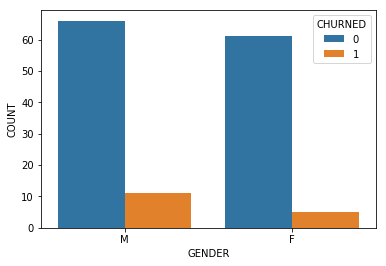

In [35]:
sns.countplot(x="gender", hue="CHURNED", data=frame[['CHURNED', 'gender']]);
plt.ylabel('COUNT');
plt.xlabel('GENDER');

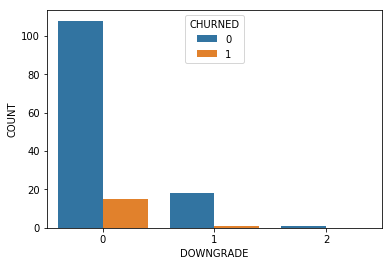

In [36]:
sns.countplot(x="DOWNGRADE", hue="CHURNED", data=frame[['CHURNED', 'DOWNGRADE']]);
plt.ylabel('COUNT');

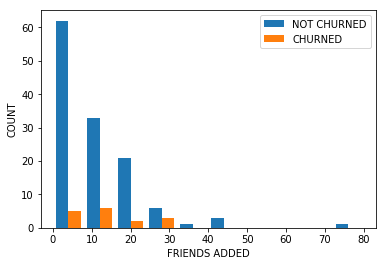

In [37]:
plt.hist([frame[frame['CHURNED']==0]['FRIENDS_ADDED'],frame[frame['CHURNED']==1]['FRIENDS_ADDED']]);
plt.ylabel('COUNT');
plt.xlabel('FRIENDS ADDED');
plt.legend(['NOT CHURNED', 'CHURNED']);

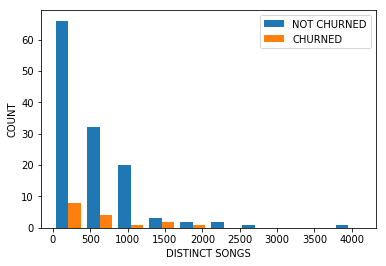

In [38]:
plt.hist([frame[frame['CHURNED']==0]['NUM_SONGS_DISTINCT'],frame[frame['CHURNED']==1]['NUM_SONGS_DISTINCT']]);
plt.ylabel('COUNT');
plt.xlabel('DISTINCT SONGS');
plt.legend(['NOT CHURNED', 'CHURNED']);

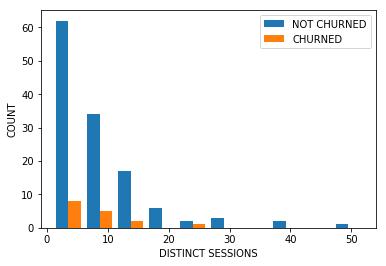

In [39]:
plt.hist([frame[frame['CHURNED']==0]['NUM_SESSIONS_DISTINCT'],frame[frame['CHURNED']==1]['NUM_SESSIONS_DISTINCT']]);
plt.ylabel('COUNT');
plt.xlabel('DISTINCT SESSIONS');
plt.legend(['NOT CHURNED', 'CHURNED']);

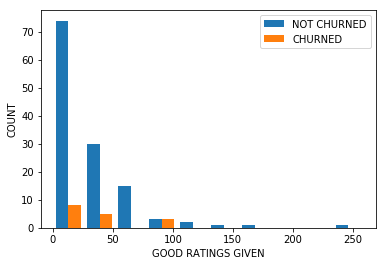

In [40]:
plt.hist([frame[frame['CHURNED']==0]['RATINGS_GIVEN_GOOD'],frame[frame['CHURNED']==1]['RATINGS_GIVEN_GOOD']]);
plt.ylabel('COUNT');
plt.xlabel('GOOD RATINGS GIVEN');
plt.legend(['NOT CHURNED', 'CHURNED']);

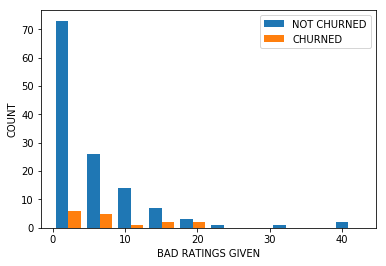

In [41]:
plt.hist([frame[frame['CHURNED']==0]['RATINGS_GIVEN_BAD'],frame[frame['CHURNED']==1]['RATINGS_GIVEN_BAD']]);
plt.ylabel('COUNT');
plt.xlabel('BAD RATINGS GIVEN');
plt.legend(['NOT CHURNED', 'CHURNED']);

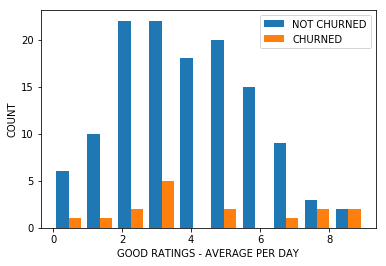

In [42]:
plt.hist([frame[frame['CHURNED']==0]['AVG_RATINGS_PER_DAY_GOOD'],frame[frame['CHURNED']==1]['AVG_RATINGS_PER_DAY_GOOD']]);
plt.ylabel('COUNT');
plt.xlabel('GOOD RATINGS - AVERAGE PER DAY');
plt.legend(['NOT CHURNED', 'CHURNED']);

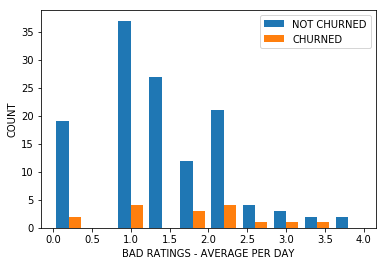

In [43]:
plt.hist([frame[frame['CHURNED']==0]['AVG_RATINGS_PER_DAY_BAD'],frame[frame['CHURNED']==1]['AVG_RATINGS_PER_DAY_BAD']]);
plt.ylabel('COUNT');
plt.xlabel('BAD RATINGS - AVERAGE PER DAY');
plt.legend(['NOT CHURNED', 'CHURNED']);

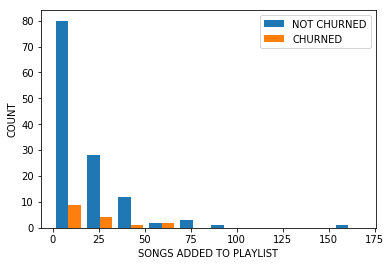

In [44]:
plt.hist([frame[frame['CHURNED']==0]['SONGS_ADDED_TO_PLAYLIST'],frame[frame['CHURNED']==1]['SONGS_ADDED_TO_PLAYLIST']]);
plt.ylabel('COUNT');
plt.xlabel('SONGS ADDED TO PLAYLIST');
plt.legend(['NOT CHURNED', 'CHURNED']);

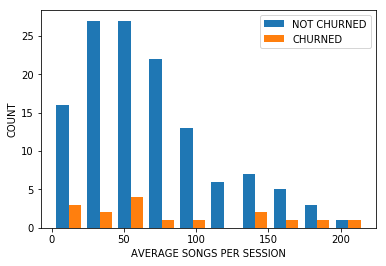

In [45]:
plt.hist([frame[frame['CHURNED']==0]['AVG_SONGS_PER_SESSION'],frame[frame['CHURNED']==1]['AVG_SONGS_PER_SESSION']]);
plt.ylabel('COUNT');
plt.xlabel('AVERAGE SONGS PER SESSION');
plt.legend(['NOT CHURNED', 'CHURNED']);

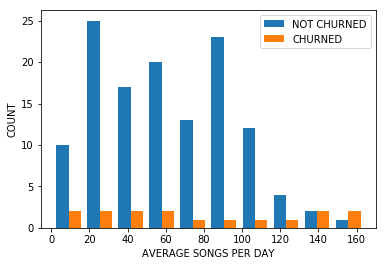

In [46]:
plt.hist([frame[frame['CHURNED']==0]['AVG_SONGS_PER_DAY'],frame[frame['CHURNED']==1]['AVG_SONGS_PER_DAY']]);
plt.ylabel('COUNT');
plt.xlabel('AVERAGE SONGS PER DAY');
plt.legend(['NOT CHURNED', 'CHURNED']);

In [47]:
def plot(feature, roundby=-1): 
    
    round_dict = {0: '1s', -1: '10s', -2: '100s'}

    temp = frame
    temp['rounded'] = temp[feature].apply(lambda x: round(x,roundby))
    temp1 = temp[['rounded', 'CHURNED']]
    temp2 = temp.groupby('rounded')['rounded'].first()
    temp3 = temp.groupby('rounded')['CHURNED'].mean()
    temp4 = temp.groupby('rounded')['rounded'].count()
    
    fig, ax1 = plt.subplots()

    #plot churn rate per rounded bucket:
    color = 'tab:blue'
    ax1.set_xlabel(feature + ' ROUNDED TO '+round_dict[roundby])
    ax1.set_ylabel('CHURN RATIO', color=color)
    ax1.plot(temp2, temp3, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:olive'
    ax2.set_ylabel('COUNT', color=color)  # we already handled the x-label with ax1
    ax2.plot(temp2, temp4, color=color, linestyle='dashed')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

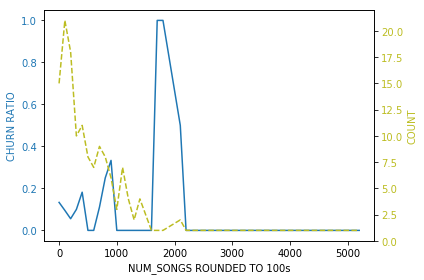

In [48]:
plot('NUM_SONGS',-2)

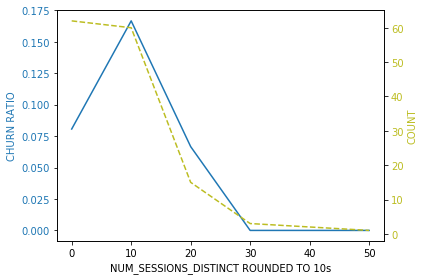

In [49]:
plot('NUM_SESSIONS_DISTINCT',-1)

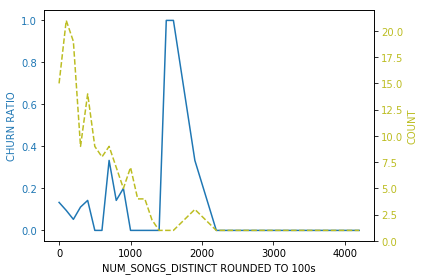

In [50]:
plot('NUM_SONGS_DISTINCT',-2)

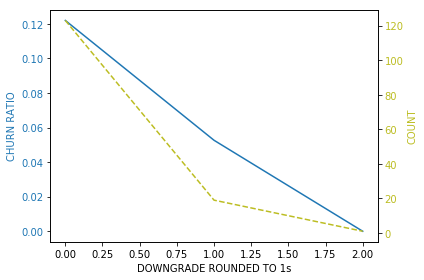

In [51]:
plot('DOWNGRADE',0)

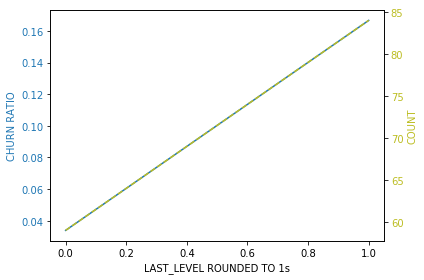

In [52]:
plot('LAST_LEVEL',0)

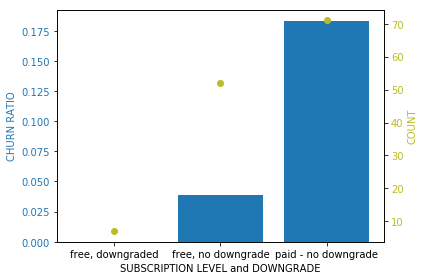

In [53]:
a= ['free, no downgrade', 'free, downgraded', 'paid - no downgrade']
x = frame[(frame['DOWNGRADE'] == 0) & (frame['LAST_LEVEL'] == 0)]['CHURNED']
y = frame[(frame['DOWNGRADE'] == 1) & (frame['LAST_LEVEL'] == 0)]['CHURNED']
z = frame[(frame['DOWNGRADE'] == 0) & (frame['LAST_LEVEL'] == 1)]['CHURNED']
b = [x.sum() / x.count(),
     y.sum() / y.count(),
     z.sum() / z.count()]
c = [
     x.count(),
     y.count(),
     z.count()
]
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('SUBSCRIPTION LEVEL and DOWNGRADE')
ax1.set_ylabel('CHURN RATIO', color=color)
ax1.bar(a, b, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:olive'
ax2.set_ylabel('COUNT', color=color)  # we already handled the x-label with ax1
ax2.plot(a, c, color=color, marker = 'o', linewidth=0)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

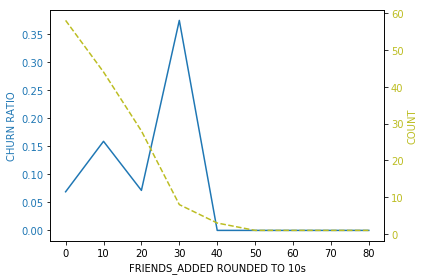

In [54]:
plot('FRIENDS_ADDED',-1)

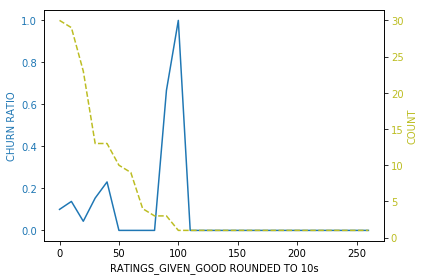

In [55]:
plot('RATINGS_GIVEN_GOOD',-1)

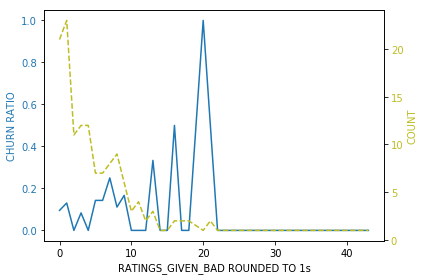

In [56]:
plot('RATINGS_GIVEN_BAD',0)

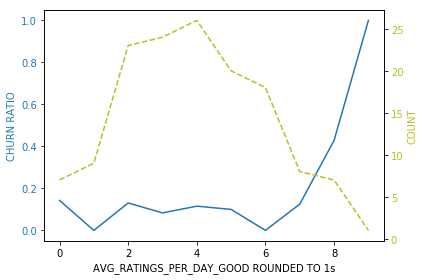

In [57]:
plot('AVG_RATINGS_PER_DAY_GOOD',0)

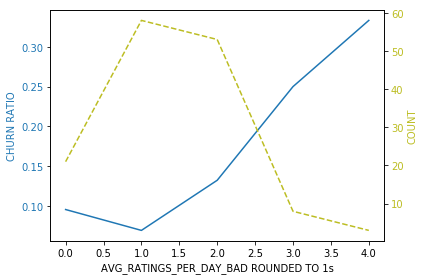

In [58]:
plot('AVG_RATINGS_PER_DAY_BAD',0)

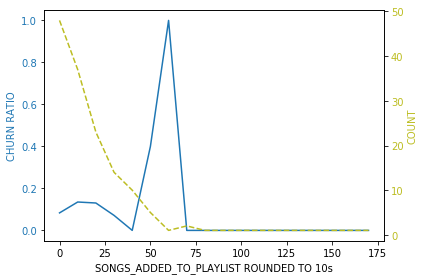

In [59]:
plot('SONGS_ADDED_TO_PLAYLIST',-1)

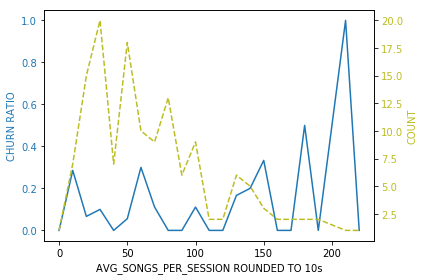

In [60]:
plot('AVG_SONGS_PER_SESSION',-1)

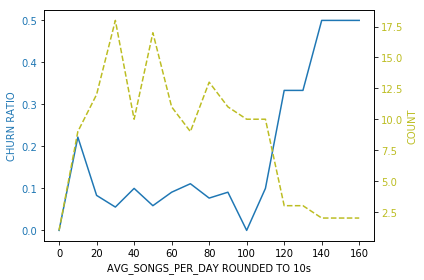

In [61]:
plot('AVG_SONGS_PER_DAY',-1)

In [62]:
num_churn = df1.groupBy('CHURNED').count()

In [63]:
churn_val = num_churn.collect()

In [64]:
churn_val

[Row(CHURNED=1, count=16), Row(CHURNED=0, count=127)]

In [65]:
#Share of zeros in CHURNED ( =  accuracy of trivial model assigning only zeros)
pd.DataFrame([[churn_val[0][1],churn_val[1][1]]]).max().max()/(churn_val[0][1]+churn_val[1][1])

0.88811188811188813

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [66]:
frame.columns

Index(['userId', 'gender', 'NUM_SESSIONS_DISTINCT', 'NUM_ARTISTS_DISTINCT',
       'NUM_SONGS_DISTINCT', 'NUM_SONGS', 'CHURNED', 'LAST_LEVEL', 'DOWNGRADE',
       'FRIENDS_ADDED', 'RATINGS_GIVEN_GOOD', 'RATINGS_GIVEN_BAD',
       'AVG_RATINGS_PER_DAY_GOOD', 'AVG_RATINGS_PER_DAY_BAD',
       'SONGS_ADDED_TO_PLAYLIST', 'AVG_SONGS_PER_SESSION', 'AVG_SONGS_PER_DAY',
       'rounded'],
      dtype='object')

In [67]:
df1.persist()

DataFrame[userId: string, gender: string, NUM_SESSIONS_DISTINCT: bigint, NUM_ARTISTS_DISTINCT: bigint, NUM_SONGS_DISTINCT: bigint, NUM_SONGS: bigint, CHURNED: int, LAST_LEVEL: int, DOWNGRADE: bigint, FRIENDS_ADDED: bigint, RATINGS_GIVEN_GOOD: bigint, RATINGS_GIVEN_BAD: bigint, AVG_RATINGS_PER_DAY_GOOD: double, AVG_RATINGS_PER_DAY_BAD: double, SONGS_ADDED_TO_PLAYLIST: bigint, AVG_SONGS_PER_SESSION: double, AVG_SONGS_PER_DAY: double]

### Train - Validation - Test Split

In [69]:
train, validation = df1.randomSplit([0.75, 0.25], seed=42)
#validation and test split probably not used, since the data is so small that we would not have many churns to detect then.
#validation, test = validation.randomSplit([0.5, 0.5], seed=42)

### Build Pipeline(s)

In [70]:
indexer = StringIndexer(inputCol="gender", outputCol="GENDER_INDEXED")   #male / female to 0 and 1

assembler = VectorAssembler(inputCols=['GENDER_INDEXED', 'NUM_SESSIONS_DISTINCT', 'NUM_ARTISTS_DISTINCT',
       'NUM_SONGS_DISTINCT', 'NUM_SONGS', 'DOWNGRADE', 'FRIENDS_ADDED', 'RATINGS_GIVEN_GOOD', 'RATINGS_GIVEN_BAD', 
                            'AVG_RATINGS_PER_DAY_GOOD', 'AVG_RATINGS_PER_DAY_BAD', 'SONGS_ADDED_TO_PLAYLIST',
                            'AVG_SONGS_PER_SESSION', 'AVG_SONGS_PER_DAY'], outputCol="FeatureVec")

scaler = MinMaxScaler(inputCol="FeatureVec", outputCol="features")

labelindexer = StringIndexer(inputCol="CHURNED", outputCol="label")

# https://spark.apache.org/docs/2.2.0/ml-classification-regression.html

lr = LogisticRegression(elasticNetParam = 0)
dt = DecisionTreeClassifier(seed = 42)
rf = RandomForestClassifier(seed =42)
#dtc = DecisionTreeClassificationModel()
#rfc = RandomForestClassificationModel()
#gbtc = GBTClassifier(seed = 42)

pipeline = dict()

models = ['lr', 'dt', 'rf']
models_real = [lr, dt, rf]

for model in zip(models, models_real):
    pipeline[model[0]] = Pipeline(stages=[indexer, assembler, scaler, labelindexer, model[1]])


### Tune Model

In [71]:
#Define Parameter Grids for cross validation

paramGrid = dict()

paramGrid['lr'] = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.1, 0.5, 1, 2]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [1, 5, 10]) \
    .build()

paramGrid['dt'] = ParamGridBuilder() \
    .addGrid(dt.minInstancesPerNode,[10, 25]) \
    .addGrid(dt.maxDepth, [2, 4, 6]) \
    .addGrid(dt.maxBins, [20, 60]) \
    .addGrid(dt.impurity, ['gini', 'entropy']) \
    .build()


paramGrid['rf'] = ParamGridBuilder() \
    .addGrid(rf.minInstancesPerNode,[10, 25]) \
    .addGrid(rf.maxDepth,[10, 30]) \
    .addGrid(rf.numTrees,[3, 5]) \
    .build()

#Since we have imbalanced classification data (few 1s for many 0s), we choose the following evaluator instead of say accuracy
#Later a look at the f1_score will also be benefitial
evaluator = BinaryClassificationEvaluator(metricName = 'areaUnderPR')
crossval = dict()
for model in models:
    crossval[model] = CrossValidator(estimator=pipeline[model],
                          estimatorParamMaps=paramGrid[model],
                          evaluator=evaluator,
                          numFolds=5, seed = 42)

In [72]:
#Fitting the training set for all models using parameter grid searches

#Restrict the models list in order to only calculate parts of the models (and save computation time):
models = ['lr', 'dt', 'rf']

cvModel = dict()

for model in models:
    cvModel[model] = crossval[model].fit(train)

In [73]:
metrics = dict()
metrics_frame = dict()


for model in models:
    metrics[model] = zip(cvModel[model].avgMetrics, paramGrid[model])
    metrics_frame[model] = pd.DataFrame([paramGrid[model], cvModel[model].avgMetrics]).transpose()

In [74]:
for model in models:    
    print(metrics_frame[model])

                                                    0          1
0   {LogisticRegression_a1cbc13272df__regParam: 0....    0.15471
1   {LogisticRegression_a1cbc13272df__regParam: 0....   0.127063
2   {LogisticRegression_a1cbc13272df__regParam: 0....   0.136893
3   {LogisticRegression_a1cbc13272df__regParam: 0....   0.130766
4   {LogisticRegression_a1cbc13272df__regParam: 0....   0.123937
5   {LogisticRegression_a1cbc13272df__regParam: 0....   0.130562
6   {LogisticRegression_a1cbc13272df__regParam: 0....  0.0956776
7   {LogisticRegression_a1cbc13272df__regParam: 0....  0.0956776
8   {LogisticRegression_a1cbc13272df__regParam: 0....  0.0956776
9   {LogisticRegression_a1cbc13272df__regParam: 0....    0.15471
10  {LogisticRegression_a1cbc13272df__regParam: 0....    0.11349
11  {LogisticRegression_a1cbc13272df__regParam: 0....   0.124385
12  {LogisticRegression_a1cbc13272df__regParam: 0....  0.0956776
13  {LogisticRegression_a1cbc13272df__regParam: 0....  0.0956776
14  {LogisticRegression_a

In [103]:
bestPipeline = dict()
bestLRModel = dict()
bestParams = dict()

for model in models:
    bestPipeline[model] = cvModel[model].bestModel
    bestLRModel[model] = bestPipeline[model].stages[4]
    bestParams[model] = bestLRModel[model].extractParamMap()

In [75]:
#Test predictions on the cross-validation set:

preds = dict()

for model in models:
    preds[model] =cvModel[model].transform(validation)

In [ ]:
#DELETE   

In [114]:
validation_table = preds['lr'].toPandas()

In [116]:
validation_table

,userId,gender,NUM_SESSIONS_DISTINCT,NUM_ARTISTS_DISTINCT,NUM_SONGS_DISTINCT,NUM_SONGS,CHURNED,LAST_LEVEL,DOWNGRADE,FRIENDS_ADDED,...,SONGS_ADDED_TO_PLAYLIST,AVG_SONGS_PER_SESSION,AVG_SONGS_PER_DAY,GENDER_INDEXED,FeatureVec,features,label,rawPrediction,probability,prediction
0,51,M,10,1385,1854,2111,1,1,0,28,...,52,211.100000,162.384615,0.0,"[0.0, 10.0, 1385.0, 1854.0, 2111.0, 0.0, 28.0,...","[0.0, 0.176470588235, 0.516032811335, 0.445968...",1.0,"[1.14862759847, -1.14862759847]","[0.759260152934, 0.240739847066]",0.0
1,15,M,9,842,1038,1117,0,1,0,17,...,30,139.625000,101.545455,0.0,"[0.0, 9.0, 842.0, 1038.0, 1117.0, 0.0, 17.0, 4...","[0.0, 0.156862745098, 0.313571961223, 0.249578...",0.0,"[1.49997558362, -1.49997558362]","[0.817570834549, 0.182429165451]",0.0
2,112,M,5,92,96,96,0,0,0,1,...,3,19.200000,24.000000,0.0,"[0.0, 5.0, 92.0, 96.0, 96.0, 0.0, 1.0, 3.0, 1....","[0.0, 0.078431372549, 0.0339299030574, 0.02286...",0.0,"[1.93724973914, -1.93724973914]","[0.874049687318, 0.125950312682]",0.0
3,42,F,25,1171,1435,1595,0,1,0,31,...,54,72.500000,79.750000,1.0,"[1.0, 25.0, 1171.0, 1435.0, 1595.0, 0.0, 31.0,...","[1.0, 0.470588235294, 0.436241610738, 0.345126...",0.0,"[1.58193948467, -1.58193948467]","[0.82947902095, 0.17052097905]",0.0
4,3,M,4,197,211,214,1,1,0,1,...,4,53.500000,42.800000,0.0,"[0.0, 4.0, 197.0, 211.0, 214.0, 0.0, 1.0, 14.0...","[0.0, 0.0588235294118, 0.0730797912006, 0.0505...",1.0,"[1.75642455186, -1.75642455186]","[0.852761294821, 0.147238705179]",0.0
5,34,M,2,39,39,39,0,0,0,0,...,3,19.500000,13.000000,0.0,"[0.0, 2.0, 39.0, 39.0, 39.0, 0.0, 0.0, 1.0, 0....","[0.0, 0.0196078431373, 0.0141685309471, 0.0091...",0.0,"[1.99904256547, -1.99904256547]","[0.880696516839, 0.119303483161]",0.0
6,139,M,1,92,95,95,0,1,0,0,...,4,95.000000,95.000000,0.0,"[0.0, 1.0, 92.0, 95.0, 95.0, 0.0, 0.0, 2.0, 0....","[0.0, 0.0, 0.0339299030574, 0.022623345367, 0....",0.0,"[1.80616033398, -1.80616033398]","[0.858897175269, 0.141102824731]",0.0
7,28,F,19,856,1025,1110,0,1,0,18,...,41,65.294118,79.285714,1.0,"[1.0, 19.0, 856.0, 1025.0, 1110.0, 0.0, 18.0, ...","[1.0, 0.352941176471, 0.318791946309, 0.246450...",0.0,"[1.61373633788, -1.61373633788]","[0.833929481783, 0.166070518217]",0.0
8,100,M,18,1000,1234,1368,0,1,0,27,...,37,76.000000,85.500000,0.0,"[0.0, 18.0, 1000.0, 1234.0, 1368.0, 0.0, 27.0,...","[0.0, 0.333333333333, 0.372483221477, 0.296750...",0.0,"[1.51331170221, -1.51331170221]","[0.819551482446, 0.180448517554]",0.0
9,120,F,9,956,1193,1301,0,1,0,18,...,36,144.555556,108.416667,1.0,"[1.0, 9.0, 956.0, 1193.0, 1301.0, 0.0, 18.0, 7...","[1.0, 0.156862745098, 0.356077554064, 0.286883...",0.0,"[1.51060281578, -1.51060281578]","[0.819150526932, 0.180849473068]",0.0


In [117]:
validation_table[['prediction', 'label']].sum()

prediction    0.0
label         3.0
dtype: float64

In [79]:
#Threshold überlegen

In [118]:
train_table = cvModel['lr'].transform(train).toPandas()

In [119]:
train_table

,userId,gender,NUM_SESSIONS_DISTINCT,NUM_ARTISTS_DISTINCT,NUM_SONGS_DISTINCT,NUM_SONGS,CHURNED,LAST_LEVEL,DOWNGRADE,FRIENDS_ADDED,...,SONGS_ADDED_TO_PLAYLIST,AVG_SONGS_PER_SESSION,AVG_SONGS_PER_DAY,GENDER_INDEXED,FeatureVec,features,label,rawPrediction,probability,prediction
0,125,M,1,8,8,8,1,0,0,0,...,0,8.000000,8.000000,0.0,"(0.0, 1.0, 8.0, 8.0, 8.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.00260999254288, 0.00168471720818,...",1.0,"[2.03456190344, -2.03456190344]","[0.884378366061, 0.115621633939]",0.0
1,124,F,13,1425,1936,2204,0,1,0,37,...,73,169.538462,146.933333,1.0,"[1.0, 13.0, 1425.0, 1936.0, 2204.0, 0.0, 37.0,...","[1.0, 0.235294117647, 0.530947054437, 0.465703...",0.0,"[1.29083837009, -1.29083837009]","[0.784289058209, 0.215710941791]",0.0
2,7,M,4,102,108,109,0,0,0,1,...,3,27.250000,21.800000,0.0,"[0.0, 4.0, 102.0, 108.0, 109.0, 0.0, 1.0, 4.0,...","[0.0, 0.0588235294118, 0.037658463833, 0.02575...",0.0,"[1.9177505361, -1.9177505361]","[0.871887379189, 0.128112620811]",0.0
3,54,F,27,1405,1851,2091,0,1,1,27,...,54,80.423077,95.045455,1.0,"[1.0, 27.0, 1405.0, 1851.0, 2091.0, 1.0, 27.0,...","[1.0, 0.509803921569, 0.523489932886, 0.445246...",0.0,"[1.54982699158, -1.54982699158]","[0.82488874264, 0.17511125736]",0.0
4,132,F,7,389,436,455,0,1,0,9,...,7,65.000000,65.000000,1.0,"[1.0, 7.0, 389.0, 436.0, 455.0, 0.0, 9.0, 20.0...","[1.0, 0.117647058824, 0.144668158091, 0.104693...",0.0,"[1.79758445297, -1.79758445297]","[0.857854637692, 0.142145362308]",0.0
5,101,M,10,1241,1608,1797,1,1,0,29,...,61,179.700000,138.230769,0.0,"[0.0, 10.0, 1241.0, 1608.0, 1797.0, 0.0, 29.0,...","[0.0, 0.176470588235, 0.462341536167, 0.386762...",1.0,"[1.23610598172, -1.23610598172]","[0.774885476778, 0.225114523222]",0.0
6,11,F,9,226,244,249,0,0,1,2,...,4,27.666667,27.666667,1.0,"[1.0, 9.0, 226.0, 244.0, 249.0, 1.0, 2.0, 15.0...","[1.0, 0.156862745098, 0.0838926174497, 0.05848...",0.0,"[2.00931585347, -2.00931585347]","[0.881771718299, 0.118228281701]",0.0
7,138,M,11,899,1111,1229,0,1,0,21,...,36,111.727273,111.727273,0.0,"[0.0, 11.0, 899.0, 1111.0, 1229.0, 0.0, 21.0, ...","[0.0, 0.196078431373, 0.334824757644, 0.267148...",0.0,"[1.44978579936, -1.44978579936]","[0.809965466109, 0.190034533891]",0.0
8,29,M,27,1563,2158,2499,0,1,0,40,...,72,92.555556,113.590909,0.0,"[0.0, 27.0, 1563.0, 2158.0, 2499.0, 0.0, 40.0,...","[0.0, 0.509803921569, 0.582401193139, 0.519133...",0.0,"[1.30485291646, -1.30485291646]","[0.786650587983, 0.213349412017]",0.0
9,69,F,6,597,692,732,0,1,0,11,...,20,122.000000,91.500000,1.0,"[1.0, 6.0, 597.0, 692.0, 732.0, 0.0, 11.0, 51....","[1.0, 0.0980392156863, 0.222222222222, 0.16630...",0.0,"[1.63306813769, -1.63306813769]","[0.836589509489, 0.163410490511]",0.0


In [120]:
train_table[['prediction', 'label']].sum()

prediction     0.0
label         13.0
dtype: float64

In [87]:
# Run cross validations
preds_pandas = dict()
recall = dict()
precision = dict()
accuracy = dict()
f1 = dict()

for model in models:
    preds_pandas[model] = preds[model].toPandas()
    print('Model: {}'.format(model))
    print('Test Area Under PR: ', evaluator.evaluate(preds[model]))
    # Calculate and print f1, recall and precision scores
    f1[model] = f1_score(preds_pandas[model].label, preds_pandas[model].prediction)
    recall[model] = recall_score(preds_pandas[model].label, preds_pandas[model].prediction)
    precision[model] = precision_score(preds_pandas[model].label, preds_pandas[model].prediction)
    accuracy[model] = accuracy_score(preds_pandas[model].label, preds_pandas[model].prediction)

    print('F1-Score: {}, Recall: {}, Precision: {}, Accuracy: {}'.format(f1[model], recall[model], precision[model], accuracy[model]))

Model: lr
Test Area Under PR:  0.390801914635586
F1-Score: 0.0, Recall: 0.0, Precision: 0.0, Accuracy: 0.896551724137931


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [104]:
bestPipeline['lr']

PipelineModel_812b699d6cca

In [105]:
bestLRModel['lr']

LogisticRegressionModel: uid = LogisticRegression_a1cbc13272df, numClasses = 2, numFeatures = 14

In [106]:
bestParams['lr']

{Param(parent='LogisticRegression_a1cbc13272df', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_a1cbc13272df', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_a1cbc13272df', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_a1cbc13272df', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_a1cbc13272df', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_a1cbc13272df', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_a1cbc13272df', name='maxIter', doc='maximum number of iterations (>= 0)'): 

In [107]:
#Obtain the training summary to use it later to choose a classification threshold that maximizes the f1 score.
#(based on https://spark.apache.org/docs/2.2.0/ml-classification-regression.html#binomial-logistic-regression)
trainingSummary = bestLRModel['lr'].summary
print('Training Summary')
print(trainingSummary)

Training Summary


In [108]:
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)
    


objectiveHistory:
0.354869379552678
0.35303979011305675


In [109]:
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))



+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|0.009900990099009901|                0.0|
|0.009900990099009901|0.07692307692307693|
|0.019801980198019802|0.07692307692307693|
|  0.0297029702970297|0.07692307692307693|
|0.039603960396039604|0.07692307692307693|
|0.039603960396039604|0.15384615384615385|
|0.039603960396039604|0.23076923076923078|
| 0.04950495049504951|0.23076923076923078|
|  0.0594059405940594|0.23076923076923078|
| 0.06930693069306931|0.23076923076923078|
| 0.07920792079207921|0.23076923076923078|
| 0.07920792079207921| 0.3076923076923077|
|  0.0891089108910891| 0.3076923076923077|
| 0.09900990099009901| 0.3076923076923077|
| 0.10891089108910891| 0.3076923076923077|
|  0.1188118811881188| 0.3076923076923077|
| 0.12871287128712872| 0.3076923076923077|
| 0.13861386138613863| 0.3076923076923077|
|  0.1485148514851485| 0.3076923076923077|
+----------

In [111]:
# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']

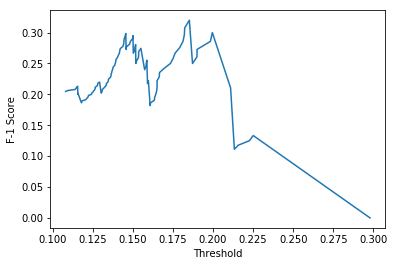

In [112]:
fm = fMeasure.toPandas()
plt.plot(fm['threshold'], fm['F-Measure'])
plt.xlabel('Threshold')
plt.ylabel('F-1 Score')
plt.show()

In [113]:
bestThreshold

0.18525856419406322

In [ ]:
#could do:
#Set new threshold
lr.setThreshold(bestThreshold)

In [121]:
#But do manually:
validation_table

,userId,gender,NUM_SESSIONS_DISTINCT,NUM_ARTISTS_DISTINCT,NUM_SONGS_DISTINCT,NUM_SONGS,CHURNED,LAST_LEVEL,DOWNGRADE,FRIENDS_ADDED,...,SONGS_ADDED_TO_PLAYLIST,AVG_SONGS_PER_SESSION,AVG_SONGS_PER_DAY,GENDER_INDEXED,FeatureVec,features,label,rawPrediction,probability,prediction
0,51,M,10,1385,1854,2111,1,1,0,28,...,52,211.100000,162.384615,0.0,"[0.0, 10.0, 1385.0, 1854.0, 2111.0, 0.0, 28.0,...","[0.0, 0.176470588235, 0.516032811335, 0.445968...",1.0,"[1.14862759847, -1.14862759847]","[0.759260152934, 0.240739847066]",0.0
1,15,M,9,842,1038,1117,0,1,0,17,...,30,139.625000,101.545455,0.0,"[0.0, 9.0, 842.0, 1038.0, 1117.0, 0.0, 17.0, 4...","[0.0, 0.156862745098, 0.313571961223, 0.249578...",0.0,"[1.49997558362, -1.49997558362]","[0.817570834549, 0.182429165451]",0.0
2,112,M,5,92,96,96,0,0,0,1,...,3,19.200000,24.000000,0.0,"[0.0, 5.0, 92.0, 96.0, 96.0, 0.0, 1.0, 3.0, 1....","[0.0, 0.078431372549, 0.0339299030574, 0.02286...",0.0,"[1.93724973914, -1.93724973914]","[0.874049687318, 0.125950312682]",0.0
3,42,F,25,1171,1435,1595,0,1,0,31,...,54,72.500000,79.750000,1.0,"[1.0, 25.0, 1171.0, 1435.0, 1595.0, 0.0, 31.0,...","[1.0, 0.470588235294, 0.436241610738, 0.345126...",0.0,"[1.58193948467, -1.58193948467]","[0.82947902095, 0.17052097905]",0.0
4,3,M,4,197,211,214,1,1,0,1,...,4,53.500000,42.800000,0.0,"[0.0, 4.0, 197.0, 211.0, 214.0, 0.0, 1.0, 14.0...","[0.0, 0.0588235294118, 0.0730797912006, 0.0505...",1.0,"[1.75642455186, -1.75642455186]","[0.852761294821, 0.147238705179]",0.0
5,34,M,2,39,39,39,0,0,0,0,...,3,19.500000,13.000000,0.0,"[0.0, 2.0, 39.0, 39.0, 39.0, 0.0, 0.0, 1.0, 0....","[0.0, 0.0196078431373, 0.0141685309471, 0.0091...",0.0,"[1.99904256547, -1.99904256547]","[0.880696516839, 0.119303483161]",0.0
6,139,M,1,92,95,95,0,1,0,0,...,4,95.000000,95.000000,0.0,"[0.0, 1.0, 92.0, 95.0, 95.0, 0.0, 0.0, 2.0, 0....","[0.0, 0.0, 0.0339299030574, 0.022623345367, 0....",0.0,"[1.80616033398, -1.80616033398]","[0.858897175269, 0.141102824731]",0.0
7,28,F,19,856,1025,1110,0,1,0,18,...,41,65.294118,79.285714,1.0,"[1.0, 19.0, 856.0, 1025.0, 1110.0, 0.0, 18.0, ...","[1.0, 0.352941176471, 0.318791946309, 0.246450...",0.0,"[1.61373633788, -1.61373633788]","[0.833929481783, 0.166070518217]",0.0
8,100,M,18,1000,1234,1368,0,1,0,27,...,37,76.000000,85.500000,0.0,"[0.0, 18.0, 1000.0, 1234.0, 1368.0, 0.0, 27.0,...","[0.0, 0.333333333333, 0.372483221477, 0.296750...",0.0,"[1.51331170221, -1.51331170221]","[0.819551482446, 0.180448517554]",0.0
9,120,F,9,956,1193,1301,0,1,0,18,...,36,144.555556,108.416667,1.0,"[1.0, 9.0, 956.0, 1193.0, 1301.0, 0.0, 18.0, 7...","[1.0, 0.156862745098, 0.356077554064, 0.286883...",0.0,"[1.51060281578, -1.51060281578]","[0.819150526932, 0.180849473068]",0.0


In [125]:
choices = [0.0, 1.0]

conditions = [
    validation_table['probability'].apply(lambda x: x[1]) < bestThreshold,
    validation_table['probability'].apply(lambda x: x[1]) >= bestThreshold
]


validation_table['prediction_adjusted'] = np.select(conditions, choices, 0.0)

In [126]:
validation_table

,userId,gender,NUM_SESSIONS_DISTINCT,NUM_ARTISTS_DISTINCT,NUM_SONGS_DISTINCT,NUM_SONGS,CHURNED,LAST_LEVEL,DOWNGRADE,FRIENDS_ADDED,...,AVG_SONGS_PER_SESSION,AVG_SONGS_PER_DAY,GENDER_INDEXED,FeatureVec,features,label,rawPrediction,probability,prediction,prediction_adjusted
0,51,M,10,1385,1854,2111,1,1,0,28,...,211.100000,162.384615,0.0,"[0.0, 10.0, 1385.0, 1854.0, 2111.0, 0.0, 28.0,...","[0.0, 0.176470588235, 0.516032811335, 0.445968...",1.0,"[1.14862759847, -1.14862759847]","[0.759260152934, 0.240739847066]",0.0,1.0
1,15,M,9,842,1038,1117,0,1,0,17,...,139.625000,101.545455,0.0,"[0.0, 9.0, 842.0, 1038.0, 1117.0, 0.0, 17.0, 4...","[0.0, 0.156862745098, 0.313571961223, 0.249578...",0.0,"[1.49997558362, -1.49997558362]","[0.817570834549, 0.182429165451]",0.0,0.0
2,112,M,5,92,96,96,0,0,0,1,...,19.200000,24.000000,0.0,"[0.0, 5.0, 92.0, 96.0, 96.0, 0.0, 1.0, 3.0, 1....","[0.0, 0.078431372549, 0.0339299030574, 0.02286...",0.0,"[1.93724973914, -1.93724973914]","[0.874049687318, 0.125950312682]",0.0,0.0
3,42,F,25,1171,1435,1595,0,1,0,31,...,72.500000,79.750000,1.0,"[1.0, 25.0, 1171.0, 1435.0, 1595.0, 0.0, 31.0,...","[1.0, 0.470588235294, 0.436241610738, 0.345126...",0.0,"[1.58193948467, -1.58193948467]","[0.82947902095, 0.17052097905]",0.0,0.0
4,3,M,4,197,211,214,1,1,0,1,...,53.500000,42.800000,0.0,"[0.0, 4.0, 197.0, 211.0, 214.0, 0.0, 1.0, 14.0...","[0.0, 0.0588235294118, 0.0730797912006, 0.0505...",1.0,"[1.75642455186, -1.75642455186]","[0.852761294821, 0.147238705179]",0.0,0.0
5,34,M,2,39,39,39,0,0,0,0,...,19.500000,13.000000,0.0,"[0.0, 2.0, 39.0, 39.0, 39.0, 0.0, 0.0, 1.0, 0....","[0.0, 0.0196078431373, 0.0141685309471, 0.0091...",0.0,"[1.99904256547, -1.99904256547]","[0.880696516839, 0.119303483161]",0.0,0.0
6,139,M,1,92,95,95,0,1,0,0,...,95.000000,95.000000,0.0,"[0.0, 1.0, 92.0, 95.0, 95.0, 0.0, 0.0, 2.0, 0....","[0.0, 0.0, 0.0339299030574, 0.022623345367, 0....",0.0,"[1.80616033398, -1.80616033398]","[0.858897175269, 0.141102824731]",0.0,0.0
7,28,F,19,856,1025,1110,0,1,0,18,...,65.294118,79.285714,1.0,"[1.0, 19.0, 856.0, 1025.0, 1110.0, 0.0, 18.0, ...","[1.0, 0.352941176471, 0.318791946309, 0.246450...",0.0,"[1.61373633788, -1.61373633788]","[0.833929481783, 0.166070518217]",0.0,0.0
8,100,M,18,1000,1234,1368,0,1,0,27,...,76.000000,85.500000,0.0,"[0.0, 18.0, 1000.0, 1234.0, 1368.0, 0.0, 27.0,...","[0.0, 0.333333333333, 0.372483221477, 0.296750...",0.0,"[1.51331170221, -1.51331170221]","[0.819551482446, 0.180448517554]",0.0,0.0
9,120,F,9,956,1193,1301,0,1,0,18,...,144.555556,108.416667,1.0,"[1.0, 9.0, 956.0, 1193.0, 1301.0, 0.0, 18.0, 7...","[1.0, 0.156862745098, 0.356077554064, 0.286883...",0.0,"[1.51060281578, -1.51060281578]","[0.819150526932, 0.180849473068]",0.0,0.0


In [127]:
choices = [0.0, 1.0]

conditions = [
    train_table['probability'].apply(lambda x: x[1]) < bestThreshold,
    train_table['probability'].apply(lambda x: x[1]) >= bestThreshold
]


train_table['prediction_adjusted'] = np.select(conditions, choices, 0.0)

In [128]:
train_table

,userId,gender,NUM_SESSIONS_DISTINCT,NUM_ARTISTS_DISTINCT,NUM_SONGS_DISTINCT,NUM_SONGS,CHURNED,LAST_LEVEL,DOWNGRADE,FRIENDS_ADDED,...,AVG_SONGS_PER_SESSION,AVG_SONGS_PER_DAY,GENDER_INDEXED,FeatureVec,features,label,rawPrediction,probability,prediction,prediction_adjusted
0,125,M,1,8,8,8,1,0,0,0,...,8.000000,8.000000,0.0,"(0.0, 1.0, 8.0, 8.0, 8.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.00260999254288, 0.00168471720818,...",1.0,"[2.03456190344, -2.03456190344]","[0.884378366061, 0.115621633939]",0.0,0.0
1,124,F,13,1425,1936,2204,0,1,0,37,...,169.538462,146.933333,1.0,"[1.0, 13.0, 1425.0, 1936.0, 2204.0, 0.0, 37.0,...","[1.0, 0.235294117647, 0.530947054437, 0.465703...",0.0,"[1.29083837009, -1.29083837009]","[0.784289058209, 0.215710941791]",0.0,1.0
2,7,M,4,102,108,109,0,0,0,1,...,27.250000,21.800000,0.0,"[0.0, 4.0, 102.0, 108.0, 109.0, 0.0, 1.0, 4.0,...","[0.0, 0.0588235294118, 0.037658463833, 0.02575...",0.0,"[1.9177505361, -1.9177505361]","[0.871887379189, 0.128112620811]",0.0,0.0
3,54,F,27,1405,1851,2091,0,1,1,27,...,80.423077,95.045455,1.0,"[1.0, 27.0, 1405.0, 1851.0, 2091.0, 1.0, 27.0,...","[1.0, 0.509803921569, 0.523489932886, 0.445246...",0.0,"[1.54982699158, -1.54982699158]","[0.82488874264, 0.17511125736]",0.0,0.0
4,132,F,7,389,436,455,0,1,0,9,...,65.000000,65.000000,1.0,"[1.0, 7.0, 389.0, 436.0, 455.0, 0.0, 9.0, 20.0...","[1.0, 0.117647058824, 0.144668158091, 0.104693...",0.0,"[1.79758445297, -1.79758445297]","[0.857854637692, 0.142145362308]",0.0,0.0
5,101,M,10,1241,1608,1797,1,1,0,29,...,179.700000,138.230769,0.0,"[0.0, 10.0, 1241.0, 1608.0, 1797.0, 0.0, 29.0,...","[0.0, 0.176470588235, 0.462341536167, 0.386762...",1.0,"[1.23610598172, -1.23610598172]","[0.774885476778, 0.225114523222]",0.0,1.0
6,11,F,9,226,244,249,0,0,1,2,...,27.666667,27.666667,1.0,"[1.0, 9.0, 226.0, 244.0, 249.0, 1.0, 2.0, 15.0...","[1.0, 0.156862745098, 0.0838926174497, 0.05848...",0.0,"[2.00931585347, -2.00931585347]","[0.881771718299, 0.118228281701]",0.0,0.0
7,138,M,11,899,1111,1229,0,1,0,21,...,111.727273,111.727273,0.0,"[0.0, 11.0, 899.0, 1111.0, 1229.0, 0.0, 21.0, ...","[0.0, 0.196078431373, 0.334824757644, 0.267148...",0.0,"[1.44978579936, -1.44978579936]","[0.809965466109, 0.190034533891]",0.0,1.0
8,29,M,27,1563,2158,2499,0,1,0,40,...,92.555556,113.590909,0.0,"[0.0, 27.0, 1563.0, 2158.0, 2499.0, 0.0, 40.0,...","[0.0, 0.509803921569, 0.582401193139, 0.519133...",0.0,"[1.30485291646, -1.30485291646]","[0.786650587983, 0.213349412017]",0.0,1.0
9,69,F,6,597,692,732,0,1,0,11,...,122.000000,91.500000,1.0,"[1.0, 6.0, 597.0, 692.0, 732.0, 0.0, 11.0, 51....","[1.0, 0.0980392156863, 0.222222222222, 0.16630...",0.0,"[1.63306813769, -1.63306813769]","[0.836589509489, 0.163410490511]",0.0,0.0


In [131]:
print('F1 Score Training: {}\nF1 Score Validation: {}'.format(
    f1_score(train_table['prediction_adjusted'], train_table['label']),
    f1_score(validation_table['prediction_adjusted'], validation_table['label'])
))

F1 Score Training: 0.32
F1 Score Validation: 0.3333333333333333


In [132]:
print('Recall Score Training: {}\nRecall Score Validation: {}'.format(
    recall_score(train_table['prediction_adjusted'], train_table['label']),
    recall_score(validation_table['prediction_adjusted'], validation_table['label'])
))

F1 Score Training: 0.3333333333333333
F1 Score Validation: 0.3333333333333333


In [134]:
print('Precision Score Training: {}\nPrecisionScore Validation: {}'.format(
    precision_score(train_table['prediction_adjusted'], train_table['label']),
    precision_score(validation_table['prediction_adjusted'], validation_table['label'])
))

Precision Score Training: 0.3076923076923077
PrecisionScore Validation: 0.3333333333333333


## Evaluation

Since we are working with the mini dataset, unforutnately, we do not have enough data to comfortably work with a 3-split into training, cross-validation, and test sets. So we perform our final evaluation of the result for our main example of the logistic regression directly on the cross-validation set.
See above.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

Github Repository: https://github.com/Smirtl/Sparkify  
Blog Post: https://medium.com/@smirtl/wouldnt-you-want-to-know-in-advance-if-a-subscriber-is-about-to-leave-you-729e06c763db